# Telecom X  parte 2  predicción de Cancelación

In [173]:
!pip install xgboost

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [175]:
import pandas as pd
import pickle
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

## Extracción del archivo tratado

In [176]:
df = pd.read_csv('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/TelecomXPT2DatLimp.csv')

# 🛠️ Preparación de los Datos

## Eliminación de columnas irrelevantes

La columna Id_Clientes es una columna que no ayuda en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [177]:
df.drop(columns=['Id_Cliente'], inplace=True)

# Encoding

se transforman las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning.

In [178]:
xVar = df.drop(columns=['abandonó_del_servicio'])
yVarObj = df['abandonó_del_servicio']
columCateg = xVar.select_dtypes(include='object').columns.tolist()

oneHot = make_column_transformer((OneHotEncoder(drop='if_binary'), columCateg), remainder='passthrough', verbose_feature_names_out=False)
xEncoded = oneHot.fit_transform(xVar)
xBinDF = pd.DataFrame(xEncoded, columns=oneHot.get_feature_names_out(xVar.columns))

encoder = LabelEncoder()
yVarObjBin = encoder.fit_transform(yVarObj)
dfBin = pd.concat([pd.DataFrame({'abandonó_del_servicio': yVarObjBin}), xBinDF], axis=1)
#print(f'Variables binarizadas',dfBin)

## Verificación de la proporción de cancelación

In [179]:
propCancel = df['abandonó_del_servicio'].value_counts(normalize=True)*100
#print(f'proporcion de la varbariable objetivo:\n', propCancel)

# Análisis de correlación con la variable objetivo
correVarObj = dfBin.corr()['abandonó_del_servicio'].sort_values(ascending=False)
#print("Correlación con la variable objetivo:")
#print(correVarObj)

x = dfBin.drop(columns=['abandonó_del_servicio'])
y = dfBin['abandonó_del_servicio']

# Estratificado para mantener proporciones
x, x_test, y, y_test = train_test_split(x, y,stratify=y, test_size = 0.15, random_state = 5)
x_train, x_val, y_train, y_val = train_test_split(x, y,stratify=y, random_state = 5)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

# print("\nDistribución en train:", y_train.value_counts(normalize=True))
# print("Distribución en test:", y_test.value_counts(normalize=True))

#Balanceo de Clases
undersampler = RandomUnderSampler(random_state=42)
xTrainBal, yTrainBal = undersampler.fit_resample(x_train, y_train)

#print("\nDistribución después de undersampling:", yTrainBal.value_counts())

# 🎯 Correlación y selección de variables

In [180]:
dfBinBal = pd.concat([pd.Series(yTrainBal, name=yVarObj.name), pd.DataFrame(xTrainBal)], axis=1)

## Análisis de correlación variables númericas

La variables `pago_total` muestran una mayor correlación con las variables `meses_permanencia` y `pagos_mensuales , ya que estas pueden ser fuertes candidatas para el modelo predictivo.

In [181]:
colmBinBalNum = df.select_dtypes(include=['number']).columns.tolist()
dfBinBalNum = dfBinBal[colmBinBalNum].copy()
dfBinBalNum.corr()*100

,adulto_mayor,meses_permanencia,pagos_mensuales,pago_total
adulto_mayor,100.000000,2.533301,21.556184,10.381295
meses_permanencia,2.533301,100.000000,22.538607,85.774553
pagos_mensuales,21.556184,22.538607,100.000000,58.598427
pago_total,10.381295,85.774553,58.598427,100.000000


## Análisis de correlación variables categóricas

La variables categóricas muestran una mayor correlación con las variables de la lista se generó un dataframe dfCorr donde se filtran las variables con una correlacion mayor al 5% y menor a 100 ya que se compara con la variable objetivo de tal forma que se eliminan las variables presentes en Servicios:

- tipo_de_contrato_Month-to-month
- soporte_técnico_No
- seguridad_en_línea_No
- servicio_internet_Fiber optic
- método_de_pago_Electronic check
- copia_en_línea_No
- protección_de_dispositivos_No
- pagos_mensuales
- facturación_digital_Yes
- películas_en_línea_No
- adulto_mayor
- TV_en_línea_No
- líneas_telefónicas_Yes
- TV_en_línea_Yes
- películas_en_línea_Yes

 **Nota:** Estas pueden ser fuertes candidatas para el modelo predictivo.

In [182]:
dfBinBalCateg = dfBinBal.drop(columns=colmBinBalNum ).copy()
# Correlación con variable objetivo
srCorr = dfBinBal.corr()[yVarObj.name].sort_values(ascending=False)*100
dfCorr = pd.DataFrame((srCorr.reset_index().rename(columns={'index': 'Servicios', yVarObj.name: 'Porcentaje_Correlación'})))
dfCorrObj = dfCorr[(dfCorr['Porcentaje_Correlación'] >= 5) &(dfCorr['Porcentaje_Correlación'] < 100)]

In [183]:
dfCorrObj

,Servicios,Porcentaje_Correlación
1,tipo_de_contrato_Month-to-month,47.739257
2,soporte_técnico_No,40.567403
3,seguridad_en_línea_No,38.382756
4,servicio_internet_Fiber optic,36.852846
5,método_de_pago_Electronic check,33.550038
6,copia_en_línea_No,29.724148
7,protección_de_dispositivos_No,28.793909
8,pagos_mensuales,25.191081
9,facturación_digital_Yes,23.610008
10,películas_en_línea_No,14.468481


## Análisis Dirigido

In [184]:
columCategBin = dfCorrObj['Servicios'].values.tolist()
dfBinBal = dfBinBal.drop(columns=columCategBin)

In [185]:
dfBinBal = dfBinBal.drop(columns=['pago_total'])

In [186]:
px.box(df, x = 'pago_total', color = 'abandonó_del_servicio').show()

px.box(df, x = 'pagos_mensuales', color = 'abandonó_del_servicio').show()

px.box(df, x = 'meses_permanencia', color = 'abandonó_del_servicio').show()

In [187]:
x = dfBinBal.drop(columns=['abandonó_del_servicio'])
y = dfBinBal['abandonó_del_servicio']

# 🤖 Modelado predictivo

## Separación de datos

In [188]:
# Estratificado para mantener proporciones
x, x_test, y, y_test = train_test_split(x, y,stratify=y, test_size = 0.15, random_state = 5)
xTrainBal, x_val, yTrainBal, y_val = train_test_split(x, y,stratify=y, random_state = 5)

# Creación de Modelos

**Se crearon los modelos tomando encuenta la siguiente iformación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.

- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

In [189]:
# Modelos
dummy = DummyClassifier()
dummy.fit(xTrainBal, yTrainBal)

## Modelo de Árbol
modeloArbol = DecisionTreeClassifier(max_depth=3, random_state=5)
modeloArbol.fit(xTrainBal, yTrainBal)
## Modelo Bosques aleatorios
mdRanArb = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
mdRanArb.fit(xTrainBal, yTrainBal)
## Modelo KNN
scaler = MinMaxScaler()
xTrainBal_norm = scaler.fit_transform(xTrainBal)
x_test_norm = scaler.transform(x_test)
knn = KNeighborsClassifier()
knn.fit(xTrainBal_norm, yTrainBal)
## Modelo SVC
svmModel = SVC(kernel='rbf', C=1.0, gamma='scale') # Crear clasificador SVM
svmModel.fit(xTrainBal_norm, yTrainBal)

SVC()

In [190]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [191]:
### Convertir datos a formato DMatrix (óptimo para XGBoost)
dtrain = xgb.DMatrix(xTrainBal_norm, label=yTrainBal)
dtest = xgb.DMatrix(x_test, label=y_test)

In [192]:
params = {
    'objective': 'binary:logistic',  # para clasificación binaria
    'max_depth': 3,                  # profundidad máxima de los árboles
    'learning_rate': 0.1,            # tasa de aprendizaje
    'subsample': 0.8,                # % porcentaje de muestras usado por árbol
    'colsample_bytree': 0.8,         # % porcentaje de características usadas por árbol
    'eval_metric': 'logloss',        # métrica de evaluación
    'seed': 42                       # semilla para reproducibilidad
}

# Entrenar el modelo
num_round = 100  # número de iteraciones (árboles)
mdXgboost = xgb.train(params, dtrain, num_round)

## Evaluación de los Modelos

#### Validando el modelos

In [193]:
from sklearn.metrics import confusion_matrix

In [194]:
from sklearn.metrics import ConfusionMatrixDisplay

#### Modelo dummy

In [195]:
yPrevisto = dummy.predict(x_val)
matrizConfusion = confusion_matrix(y_val,yPrevisto)

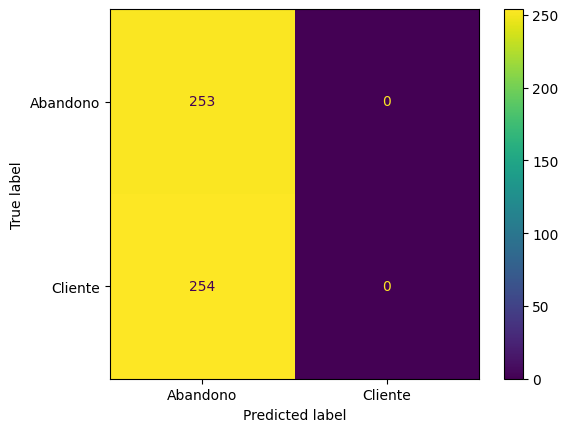

In [196]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix = matrizConfusion, display_labels=['Abandono','Cliente'])
visualizacion.plot();

In [197]:
print(f'La precisión del modelo dummy es: {dummy.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_val, yPrevisto):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_val, yPrevisto):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_val,yPrevisto)}')

La precisión del modelo dummy es: 0.5000
La sensibilidad (Recall) del modelo es:0.0000
La exactitud (accuracy) del modelo es:0.4990
El F1-score del modelo es: 0.0


#### Modelo de árbol

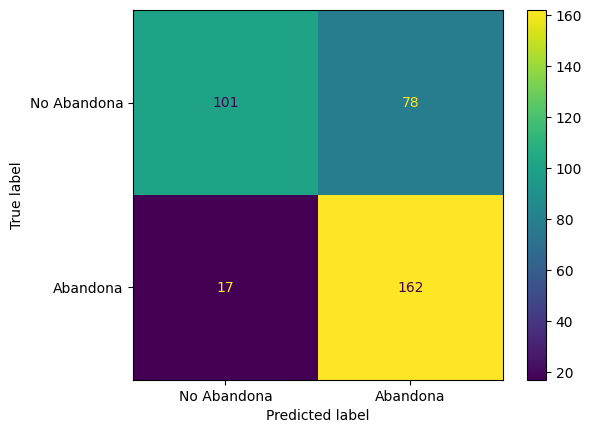

In [198]:
yPredArbol = modeloArbol.predict(x_test)
matriz = confusion_matrix(y_test, yPredArbol)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [199]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredArbol):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredArbol):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredArbol):.4f}')

La sensibilidad (Recall) del modelo es:0.9050
La exactitud (accuracy) del modelo es:0.7346
El F1-score del modelo es: 0.7733


#### Modelo bosques aleatorios

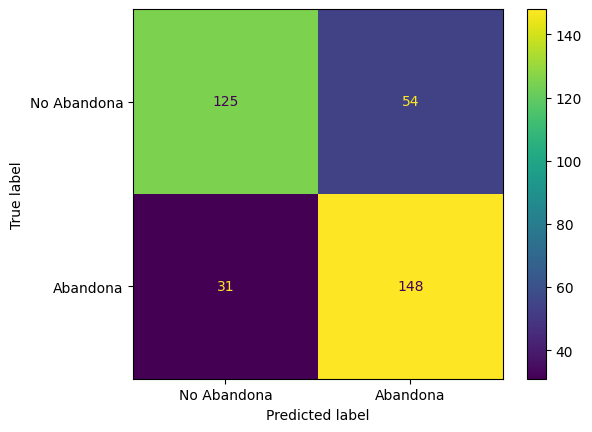

In [200]:
yPredBosqAlt = mdRanArb.predict(x_test)
matriz = confusion_matrix(y_test, yPredBosqAlt)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [201]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredBosqAlt):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredBosqAlt):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredBosqAlt):.4f}')

La sensibilidad (Recall) del modelo es:0.8268
La exactitud (accuracy) del modelo es:0.7626
El F1-score del modelo es: 0.7769


##### Modelo KNN

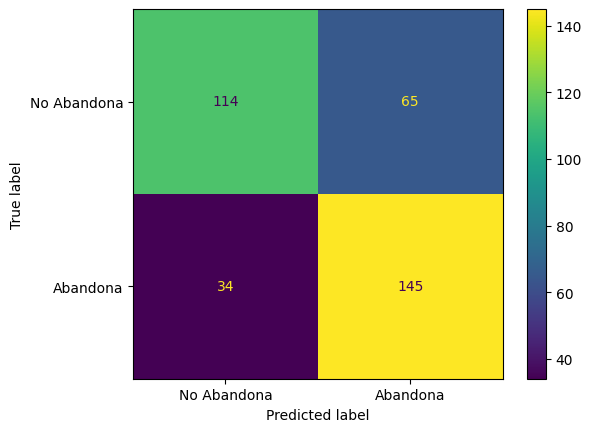

In [202]:
yPredKnn = knn.predict(x_test_norm)
matriz = confusion_matrix(y_test, yPredKnn)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [203]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredKnn):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredKnn):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredKnn):.4f}')

La sensibilidad (Recall) del modelo es:0.8101
La exactitud (accuracy) del modelo es:0.7235
El F1-score del modelo es: 0.7455


##### Modelo SVM

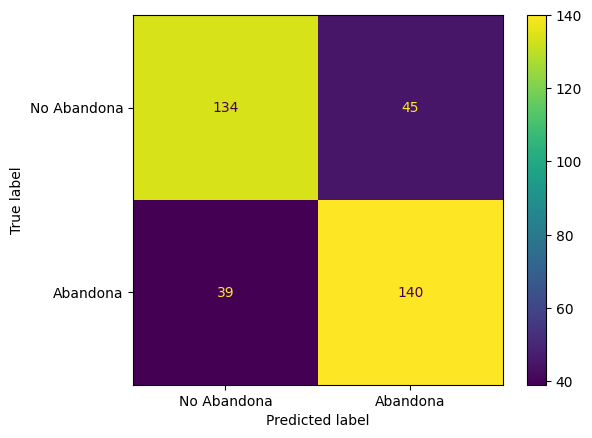

In [204]:
yPredSvm = svmModel.predict(x_test_norm)
matriz = confusion_matrix(y_test, yPredSvm)
ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=["No Abandona", "Abandona"]).plot()

In [205]:
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredSvm):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredSvm):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredSvm):.4f}')

La sensibilidad (Recall) del modelo es:0.7821
La exactitud (accuracy) del modelo es:0.7654
El F1-score del modelo es: 0.7692


## Métricas de evaluación

![](https://drive.google.com/uc?id=1PGEy9Su3gvRZ1X8jeaiSrg2MwZZ0dx1T)


$$
 \text{precision} = \frac{TP}{TP + FP}
 $$


$$
\text{recall} = \frac{TP}{TP + FN}
$$

$$
F1 = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$
$$
\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$
$$
\text{specificity} = \frac{TN}{TN + FP}
$$



### Métricas de evaluación

#### Modelo Árbol

In [206]:
print(f'La precisión del modelo Árbol es: {modeloArbol.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredArbol):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredArbol):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredArbol):.4f}')

La precisión del modelo Árbol es: 0.7346
La sensibilidad (Recall) del modelo es:0.9050
La exactitud (accuracy) del modelo es:0.7346
El F1-score del modelo es: 0.7733


#### Modelo Bosque aleatorios

In [207]:
print(f'La precisión del modelo Bosques aleatorios es: {mdRanArb.score(x_test, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredBosqAlt):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredBosqAlt):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredBosqAlt):.4f}')

La precisión del modelo Bosques aleatorios es: 0.7626
La sensibilidad (Recall) del modelo es:0.8268
La exactitud (accuracy) del modelo es:0.7626
El F1-score del modelo es: 0.7769


#### Modelo Knn

In [208]:
print(f'La precisión del modelo KNN es: {knn.score(x_test_norm, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredKnn):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredKnn):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredKnn):.4f}')

La precisión del modelo KNN es: 0.7235
La sensibilidad (Recall) del modelo es:0.8101
La exactitud (accuracy) del modelo es:0.7235
El F1-score del modelo es: 0.7455


#### Modelo SVM

In [209]:
print(f'La precisión del modelo SVC es: {svmModel.score(x_test_norm, y_test):.4f}')
print(f'La sensibilidad (Recall) del modelo es:{recall_score(y_test, yPredSvm):.4f}')
print(f'La exactitud (accuracy) del modelo es:{accuracy_score(y_test, yPredSvm):.4f}')
print(f'El F1-score del modelo es: {f1_score(y_test,yPredSvm):.4f}')

La precisión del modelo SVC es: 0.7654
La sensibilidad (Recall) del modelo es:0.7821
La exactitud (accuracy) del modelo es:0.7654
El F1-score del modelo es: 0.7692


#### Métricas de modelo XGBoots


🔎 Evaluando modelo: Xgboost
📌 Accuracy : 0.7598
📌 Precision: 0.7385
📌 Recall   : 0.8045
📌 F1-score : 0.7701

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 No Abandona       0.79      0.72      0.75       179
    Abandona       0.74      0.80      0.77       179

    accuracy                           0.76       358
   macro avg       0.76      0.76      0.76       358
weighted avg       0.76      0.76      0.76       358

📊 Predicciones únicas: (array([0, 1]), array([163, 195]))


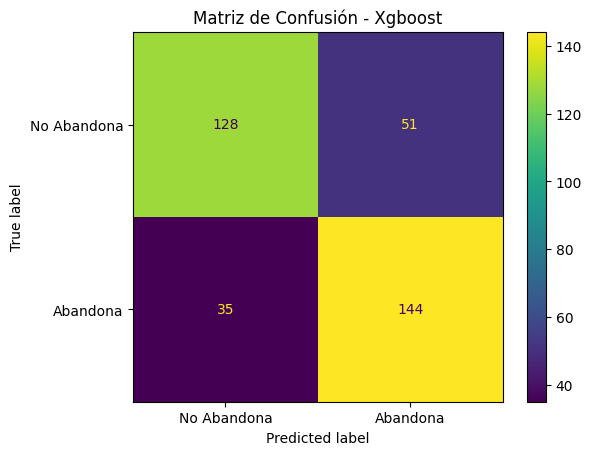

In [210]:
def evaluar_modelo(nombre, modelo, x_test, y_test, normalizado=False):
    print(f"\n🔎 Evaluando modelo: {nombre}")

    # Usar datos normalizados si es necesario
    datos = x_test_norm if normalizado else x_test

    # Predicción para XGBoost
    dtest = xgb.DMatrix(datos)
    y_pred = modelo.predict(dtest)
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Reporte de clasificación
    print(f"📌 Accuracy : {acc:.4f}")
    print(f"📌 Precision: {prec:.4f}")
    print(f"📌 Recall   : {rec:.4f}")
    print(f"📌 F1-score : {f1:.4f}")
    print("\n📄 Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Abandona", "Abandona"]))

    # Distribución de predicciones
    print("📊 Predicciones únicas:", np.unique(y_pred, return_counts=True))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Abandona", "Abandona"])
    disp.plot()
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

# Evaluar solo el modelo XGBoost
evaluar_modelo('Xgboost', mdXgboost, x_test, y_test, normalizado=True)

El modelo XGBoost es efectivo para detectar abandonos (Recall=0.80), pero requiere ajustes para reducir falsas alarmas (FP). Prioriza la métrica según el impacto empresarial:

- Evitar FN (Recall): Mantén XGBoost y optimiza el threshold.

- Evitar FP (Precisión): Prueba class_weight o usa Bosques Aleatorios.

#### Precisión de los modelos

In [211]:
modelos = [('Dummy', dummy, x_test), ('Árbol', modeloArbol, x_test), ('Bosques aleatorios', mdRanArb, x_test), ('KNN', knn, x_test_norm), ('SVC', svmModel, x_test_norm)]
_ = list(print(f'La precisión del modelo {nombre} es: {modelo.score(datos, y_test):.4f}') for nombre, modelo, datos in modelos)

La precisión del modelo Dummy es: 0.5000
La precisión del modelo Árbol es: 0.7346
La precisión del modelo Bosques aleatorios es: 0.7626
La precisión del modelo KNN es: 0.7235
La precisión del modelo SVC es: 0.7654


In [212]:
# Evaluación
modelos = [('Dummy', dummy, x_test), ('Árbol', modeloArbol, x_test),('Bosques aleatorios',mdRanArb,x_test), ('KNN', knn, x_test_norm),('SVC',svmModel,x_test_norm)]
for nombre, modelo, datos in modelos:
    print(f'La precisión del modelo {nombre} es: {modelo.score(datos, y_test):.4f}')

La precisión del modelo Dummy es: 0.5000
La precisión del modelo Árbol es: 0.7346
La precisión del modelo Bosques aleatorios es: 0.7626
La precisión del modelo KNN es: 0.7235
La precisión del modelo SVC es: 0.7654


##### Desempeño de los modelos

El desempeño de los modelos entre más lejos este el valor de uno (1) es que presenta peor desempeño.

In [213]:
modelos = [('Árbol', yPredArbol),('BosquesAleatorios', yPredBosqAlt), ('KNN', yPredKnn),('SVC', yPredSvm)]
for nombre, datos in modelos:
    print(f'Desempeño del modelo {nombre} es: {f1_score(y_test,datos):.4f}')

Desempeño del modelo Árbol es: 0.7733
Desempeño del modelo BosquesAleatorios es: 0.7769
Desempeño del modelo KNN es: 0.7455
Desempeño del modelo SVC es: 0.7692


# Curva ROC (Caracteristica Operativa del Receptor)

### Modelo de Árbol

In [214]:
from sklearn.metrics import roc_curve, auc

In [215]:
from sklearn.metrics import RocCurveDisplay

In [216]:
from sklearn.metrics import roc_auc_score

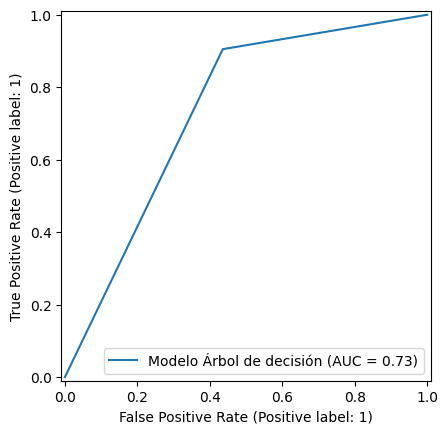

In [217]:
RocCurveDisplay.from_predictions (y_test, yPredArbol, name = 'Modelo Árbol de decisión');

In [218]:
print(f'El área bajo la curva (AUC) del modelo es: {roc_auc_score(y_test, yPredArbol):.4f}')

El área bajo la curva (AUC) del modelo es: 0.7346


### Modelo bosque aleatorio

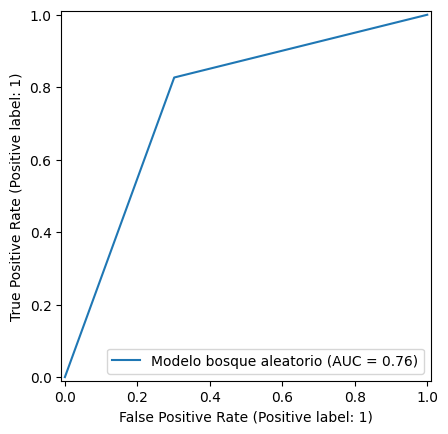

In [219]:
RocCurveDisplay.from_predictions (y_test, yPredBosqAlt, name = 'Modelo bosque aleatorio');

In [220]:
print(f'El área bajo la curva (AUC) del modelo es: {roc_auc_score(y_test, yPredBosqAlt):.4f}')

El área bajo la curva (AUC) del modelo es: 0.7626


### Modelo KNN

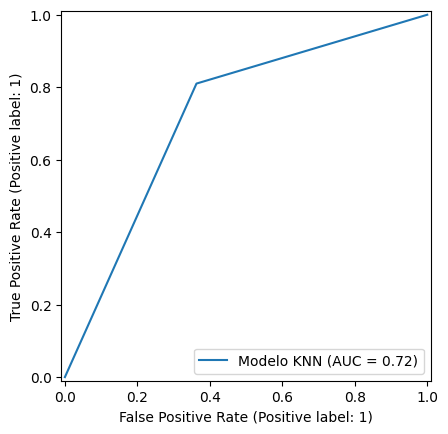

In [221]:
RocCurveDisplay.from_predictions (y_test, yPredKnn, name = 'Modelo KNN');

In [222]:
print(f'El área bajo la curva (AUC) del modelo es: {roc_auc_score(y_test, yPredKnn):.4f}')

El área bajo la curva (AUC) del modelo es: 0.7235


### SVM

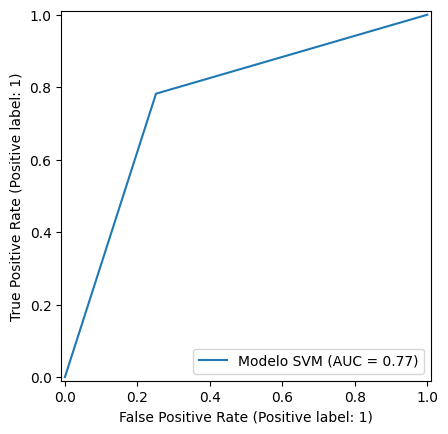

In [223]:
RocCurveDisplay.from_predictions (y_test, yPredSvm, name = 'Modelo SVM');

In [224]:
print(f'El área bajo la curva (AUC) del modelo es: {roc_auc_score(y_test, yPredSvm):.4f}')

El área bajo la curva (AUC) del modelo es: 0.7654


# Curva de precisión vs sensibilidad

In [225]:
from sklearn.metrics import PrecisionRecallDisplay

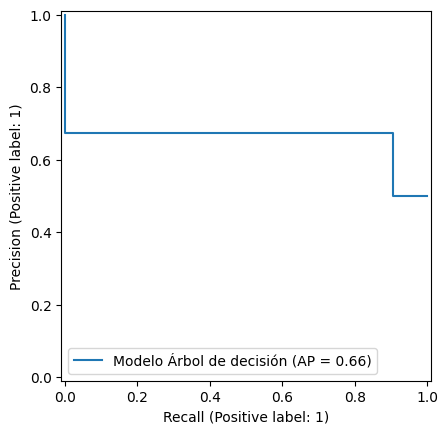

In [226]:
PrecisionRecallDisplay.from_predictions(y_test, yPredArbol, name = 'Modelo Árbol de decisión');

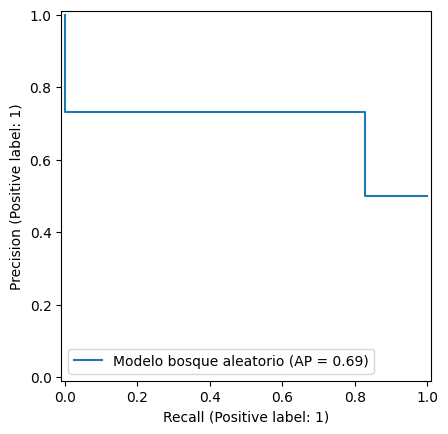

In [227]:
PrecisionRecallDisplay.from_predictions(y_test, yPredBosqAlt, name = 'Modelo bosque aleatorio');

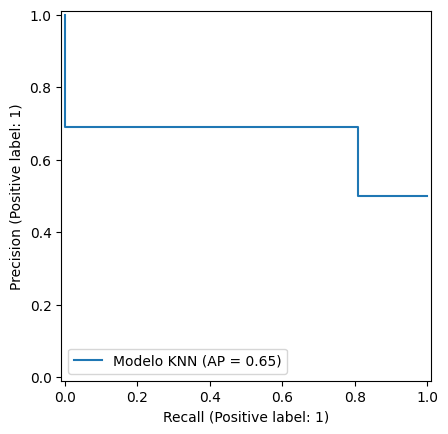

In [228]:
PrecisionRecallDisplay.from_predictions(y_test, yPredKnn, name = 'Modelo KNN');

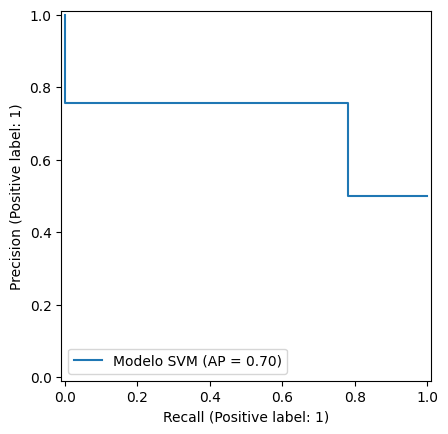

In [229]:
PrecisionRecallDisplay.from_predictions(y_test, yPredSvm, name = 'Modelo SVM');

### Informe de métricas

In [230]:
from sklearn.metrics import classification_report

In [231]:
print(classification_report(y_test, yPredArbol))

              precision    recall  f1-score   support

           0       0.86      0.56      0.68       179
           1       0.68      0.91      0.77       179

    accuracy                           0.73       358
   macro avg       0.77      0.73      0.73       358
weighted avg       0.77      0.73      0.73       358



In [232]:
print(classification_report(y_test, yPredBosqAlt))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75       179
           1       0.73      0.83      0.78       179

    accuracy                           0.76       358
   macro avg       0.77      0.76      0.76       358
weighted avg       0.77      0.76      0.76       358



In [233]:
print(classification_report(y_test, yPredKnn))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       179
           1       0.69      0.81      0.75       179

    accuracy                           0.72       358
   macro avg       0.73      0.72      0.72       358
weighted avg       0.73      0.72      0.72       358



In [234]:
print(classification_report(y_test, yPredSvm))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       179
           1       0.76      0.78      0.77       179

    accuracy                           0.77       358
   macro avg       0.77      0.77      0.77       358
weighted avg       0.77      0.77      0.77       358



# Validación cruzada usando KFold

In [235]:
from sklearn.model_selection import KFold, cross_validate

### Modelo Árbol

In [236]:
modeloArbol = DecisionTreeClassifier(max_depth=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cvResultadoArbol = cross_validate(modeloArbol,x,y,cv=kf,scoring='f1')
cvResultadoArbol

{'fit_time': array([0.01030254, 0.00900149, 0.01025224, 0.06136012, 0.00972033]),
 'score_time': array([0.00729728, 0.00840831, 0.00902581, 0.00830626, 0.0098772 ]),
 'test_score': array([0.72682927, 0.70283019, 0.74832962, 0.70588235, 0.73557692])}

In [237]:
cvResultadoArbol['test_score']

array([0.72682927, 0.70283019, 0.74832962, 0.70588235, 0.73557692])

In [238]:
promedio = cvResultadoArbol['test_score'].mean()
desvioStd = cvResultadoArbol['test_score'].std()
print(f'El promedio de la exactitud es de: {promedio}')
print(f'El desvío típico es de: {desvioStd}')
print(f'El intervalo de confianza es: [{promedio-2*desvioStd},{min(promedio+2*desvioStd,1)}]')

El promedio de la exactitud es de: 0.7238896708741749
El desvío típico es de: 0.017379928465104423
El intervalo de confianza es: [0.689129813943966,0.7586495278043838]


#### Modelo Bosque áleatorio

In [239]:
modeloBosqueAleatorio = DecisionTreeClassifier(max_depth=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cvResultadoBosqueAleatorio = cross_validate(modeloBosqueAleatorio,x,y,cv=kf,scoring='f1')
cvResultadoBosqueAleatorio

{'fit_time': array([0.02497315, 0.01033711, 0.01179457, 0.00949407, 0.01943922]),
 'score_time': array([0.00756145, 0.00763392, 0.00723886, 0.00734186, 0.01362371]),
 'test_score': array([0.72422062, 0.69953052, 0.75615213, 0.70904645, 0.73333333])}

In [240]:
cvResultadoBosqueAleatorio['test_score']

array([0.72422062, 0.69953052, 0.75615213, 0.70904645, 0.73333333])

In [241]:
promedio = cvResultadoBosqueAleatorio ['test_score'].mean()
desvioStd = cvResultadoBosqueAleatorio ['test_score'].std()
print(f'El promedio de la exactitud es de: {promedio}')
print(f'El desvío típico es de: {desvioStd}')
print(f'El intervalo de confianza es: [{promedio-2*desvioStd},{min(promedio+2*desvioStd,1)}]')

El promedio de la exactitud es de: 0.7244566106627651
El desvío típico es de: 0.01970908734798946
El intervalo de confianza es: [0.6850384359667862,0.7638747853587441]


#### Modelo KNN

In [242]:
modeloKNN = DecisionTreeClassifier(max_depth=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cvResultadoKNN = cross_validate(modeloBosqueAleatorio,x,y,cv=kf,scoring='f1')
cvResultadoKNN

{'fit_time': array([0.01029754, 0.01064444, 0.00931072, 0.01843524, 0.01184201]),
 'score_time': array([0.01303697, 0.00705624, 0.00672698, 0.00727177, 0.01682472]),
 'test_score': array([0.72596154, 0.7       , 0.7505618 , 0.71253071, 0.73333333])}

In [243]:
cvResultadoKNN['test_score']

array([0.72596154, 0.7       , 0.7505618 , 0.71253071, 0.73333333])

In [244]:
promedio = cvResultadoKNN['test_score'].mean()
desvioStd = cvResultadoKNN['test_score'].std()
print(f'El promedio de la exactitud es de: {promedio}')
print(f'El desvío típico es de: {desvioStd}')
print(f'El intervalo de confianza es: [{promedio-2*desvioStd},{min(promedio+2*desvioStd,1)}]')

El promedio de la exactitud es de: 0.7244774764156787
El desvío típico es de: 0.01733719977691808
El intervalo de confianza es: [0.6898030768618426,0.7591518759695148]


### Modelo SVM

In [245]:
modeloSVM = DecisionTreeClassifier(max_depth=10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cvResultadoSVM = cross_validate(modeloBosqueAleatorio,x,y,cv=kf,scoring='f1')
cvResultadoSVM

{'fit_time': array([0.02371979, 0.02471709, 0.02557111, 0.01009727, 0.012254  ]),
 'score_time': array([0.013376  , 0.01319075, 0.0094676 , 0.00772309, 0.00675392]),
 'test_score': array([0.72682927, 0.70283019, 0.74887892, 0.70415648, 0.73031026])}

In [246]:
cvResultadoSVM['test_score']

array([0.72682927, 0.70283019, 0.74887892, 0.70415648, 0.73031026])

In [247]:
promedio = cvResultadoSVM['test_score'].mean()
desvioStd = cvResultadoSVM['test_score'].std()
print(f'El promedio de la exactitud es de: {promedio}')
print(f'El desvío típico es de: {desvioStd}')
print(f'El intervalo de confianza es: [{promedio-2*desvioStd},{min(promedio+2*desvioStd,1)}]')

El promedio de la exactitud es de: 0.7226010244972363
El desvío típico es de: 0.01731430383338307
El intervalo de confianza es: [0.6879724168304702,0.7572296321640024]


In [248]:
# Guardar los modelos CORRECTAMENTE (usando los nombres originales)
with open('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloOnehotEncoderTelecomXChurn.pkl', 'wb') as archivo:
    pickle.dump(oneHot, archivo)

with open('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloChampionBosquesAleatoriosTelecomXChurn.pkl', 'wb') as archivo:
    pickle.dump(mdRanArb, archivo)

In [249]:
# Cargar los modelos (usa el mismo nombre)
oneHot = pd.read_pickle('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloOnehotEncoderTelecomXChurn.pkl')
modeloBosqueAleatorio = pd.read_pickle('/content/drive/MyDrive/Alura/3-EstadisticasyMachineLearningG8ONE/8-ChallengeTelecomXPT2/modeloChampionBosquesAleatoriosTelecomXChurn.pkl')

# 📋 Interpretación y conclusiones

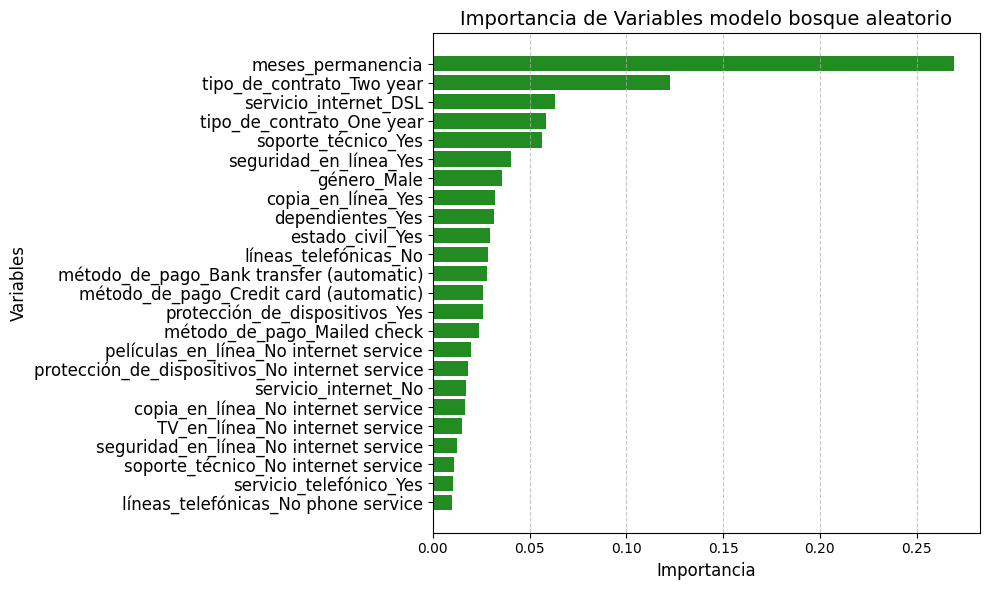

In [250]:
# 1. Obtener importancia de variables
importances = mdRanArb.feature_importances_
features = x.columns

# 2. Ordenar importancia
indices = np.argsort(importances)[::-1]  # Orden descendente

# 5. Ordenar importancia (mayor a menor)
indices = np.argsort(importances)  # Usamos esto para ordenar ASC (el gráfico horizontal invertirá el orden)

# 6. Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.title("Importancia de Variables modelo bosque aleatorio", fontsize=14)
plt.barh(range(len(importances)), importances[indices], align='center', color='forestgreen')
plt.yticks(range(len(importances)), features[indices], fontsize=12)
plt.xlabel("Importancia", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Líneas verticales de fondo
plt.tight_layout()

##### Desempeño General del Modelo
El modelo muestra un desempeño equilibrado con:
- **Exactitud (Accuracy)**: 76.26% - El modelo clasifica correctamente aproximadamente 3 de cada 4 casos.
- **Precisión**: 76.26% para la clase positiva (1) - Cuando predice abandono, acierta en el 76% de los casos.
- **Sensibilidad (Recall)**: 82.68% - Captura el 83% de los casos reales de abandono.
- **F1-Score**: 77.69% - Combinación armónica de precisión y recall, indicando un buen balance.

### Análisis de Variables Importantes

#### Variables más influyentes (positivas):
1. **meses_permanencia**: Claramente la variable más importante, lo que sugiere que el tiempo que un cliente lleva con la compañía es el principal predictor de abandono.
2. **tipo_de_contrato_Two_year**: Los contratos a largo plazo reducen significativamente la probabilidad de abandono.
3. **servicio_internet_DSL**: Tener servicio DSL parece ser un factor de retención importante.
4. **tipo_de_contrato_One_year**: Similar al de dos años, pero con menor impacto.
5. **soporte_técnico_Yes** y **seguridad_en_linea_Yes**: Servicios adicionales que aumentan la retención.

##### Variables influyentes (negativas):
Las variables que incluyen "No internet service" aparecen como importantes pero probablemente tienen un efecto negativo en la retención, indicando que la falta de estos servicios está asociada con mayor abandono.

##### Variables demográficas:
- **género_Male**: Aparece como relevante pero no entre las más importantes.
- **dependientes_Yes** y **estado_civil_Yes**: Tienen algún impacto pero menor que las variables de servicio.

#### Relación entre Variables Importantes y Métricas

1. **Alta sensibilidad (recall)**: El modelo es particularmente bueno detectando casos positivos (abandono), lo que podría estar relacionado con la fuerte influencia de variables como "meses_permanencia" que probablemente muestran patrones claros en clientes que están por abandonar.

2. **Precisión moderada**: La presencia de variables como los métodos de pago (que aparecen menos importantes) podría estar introduciendo cierto ruido, limitando la precisión.

3. **Balance general**: La combinación de variables contractuales (tiempo de permanencia, tipo de contrato) con variables de servicio (internet, soporte técnico) permite al modelo capturar diferentes aspectos del comportamiento del cliente, resultando en métricas equilibradas.

#### Recomendaciones de Acción

1. **Enfoque en retención temprana**: Dado que "meses_permanencia" es la variable más importante, implementar programas especiales para clientes nuevos podría ser crucial.

2. **Incentivar contratos a largo plazo**: Las variables de tipo de contrato son muy influyentes, por lo que promociones que incentiven contratos de 1 o 2 años podrían reducir el abandono.

3. **Paquetes de servicios**: Promover servicios adicionales como soporte técnico y seguridad en línea, que aparecen como factores positivos de retención.

4. **Revisar oferta de internet**: El servicio DSL aparece como positivo, mientras que la ausencia de servicios de internet aparece como negativo, sugiriendo que la calidad/conectividad es un factor clave.


**Hallazgos clave:**

  - Los contratos a corto plazo están fuertemente asociados con mayor abandono
  - Los clientes con más tiempo en el servicio tienen mayor probabilidad de abandonar
  - La facturación digital está ligeramente asociada con mayor abandono
  - Los clientes con dependientes y aquellos casados tienen menor probabilidad de abandonar

**Recomendaciones estratégicas**

  - Programas de fidelización: Implementar incentivos para que los clientes con contratos mensuales migren a contratos anuales o bianuales.

  - Intervenciones tempranas: Desarrollar estrategias de retención específicas para clientes que alcanzan los 6-12 meses de permanencia, cuando el riesgo de abandono aumenta.

  - Optimización de facturación digital: Investigar por qué la facturación digital correlaciona con mayor abandono y mejorar la experiencia del usuario.

  - Programas familiares: Desarrollar ofertas para clientes con dependientes, ya que muestran menor propensión al abandono.

  - Monitoreo continuo: Establecer un sistema de alerta temprana basado en los factores de riesgo identificados para intervenir proactivamente.

**Próximos Pasos para el Equipo de Data Science**

  - Desarrollar un modelo predictivo de evasión de Clientes utilizando las variables identificadas como más correlacionadas.
  - Segmentar la base de clientes según riesgo de abandono para estrategias personalizadas.
  - Implementar pruebas A/B para las estrategias de retención propuestas.
  - Establecer métricas claras para medir el impacto de las iniciativas de reducción de evasión de Clientes.

